# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» yужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Задача:

Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

# Описание данных
- Данные геологоразведки трёх регионов находятся в файлах: 

    /datasets/geo_data_0.csv. 
    
    /datasets/geo_data_1.csv. 
    
    /datasets/geo_data_2.csv. 
    

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).



Условия задачи:
    
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки:
- pandas для работы с табличными данными
- sklearn,numpy для работы с моделями машинного обучения
- matplotlib и seaborn для построения графиков
- scipy для методов статистики

In [38]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy.random import RandomState
from scipy import stats as st
import numpy as np
!pip install pandas_profiling --upgrade
from pandas_profiling import ProfileReport

sns.set_theme() 

     |████████████████████████████████| 324 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 344 kB 33.2 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 71.2 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 57.8 MB/s eta 0:00:01
     |████████████████████████████████| 679 kB 57.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 73.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 64.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 39.5 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=21348ed07ac77bb101d17f56a1830e33db3d6cfcbc8713f5b1604fdc7c2cadd6
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin


/tmp/ipykernel_176/4198362773.py:14: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [39]:
# Выгружаем данные из csv-файла в DataFrame

df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [40]:
df_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [41]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [42]:
df_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [43]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [44]:
df_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [45]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [46]:
# Выведем в удобном формате основные характеристики датафрейма
profile_1 = ProfileReport(df_1, minimal=True)
profile_1

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
# Выведем в удобном формате основные характеристики датафрейма
profile_2 = ProfileReport(df_2, minimal=True)
profile_2

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
# Выведем в удобном формате основные характеристики датафрейма
profile_3 = ProfileReport(df_3, minimal=True)
profile_3

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

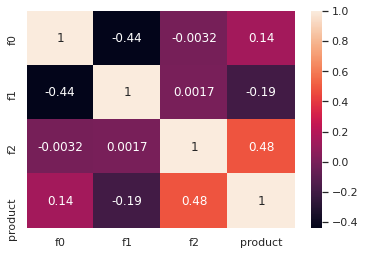

In [49]:
# Выведем корреляционную матрицу для датафрейма
sns.heatmap(df_1.corr(), annot=True)

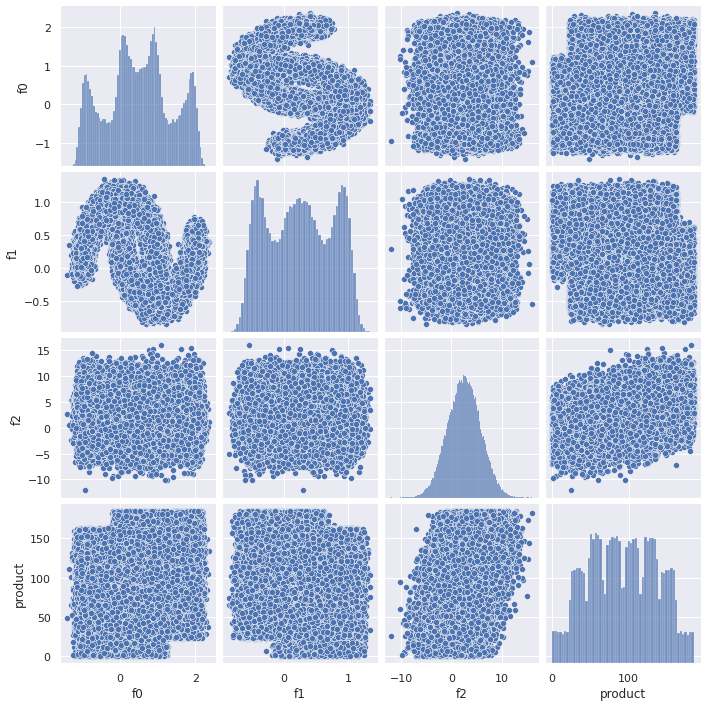

In [50]:
sns.pairplot(df_1)

<AxesSubplot:>

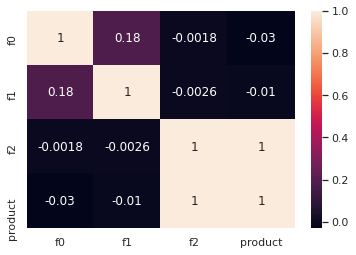

In [51]:
# Выведем корреляционную матрицу для датафрейма
sns.heatmap(df_2.corr(), annot=True)

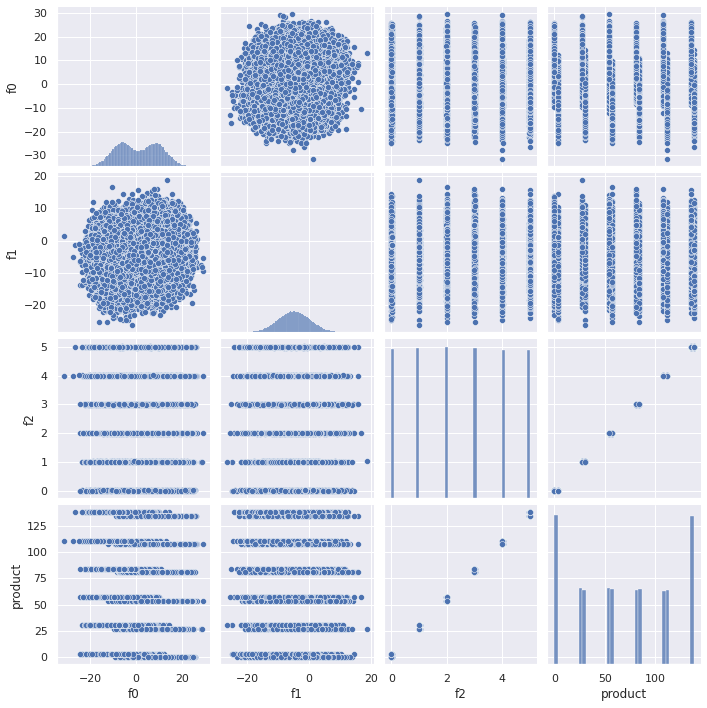

In [52]:
sns.pairplot(df_2)

<AxesSubplot:>

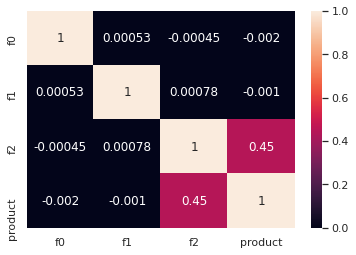

In [53]:
# Выведем корреляционную матрицу для датафрейма
sns.heatmap(df_3.corr(), annot=True)

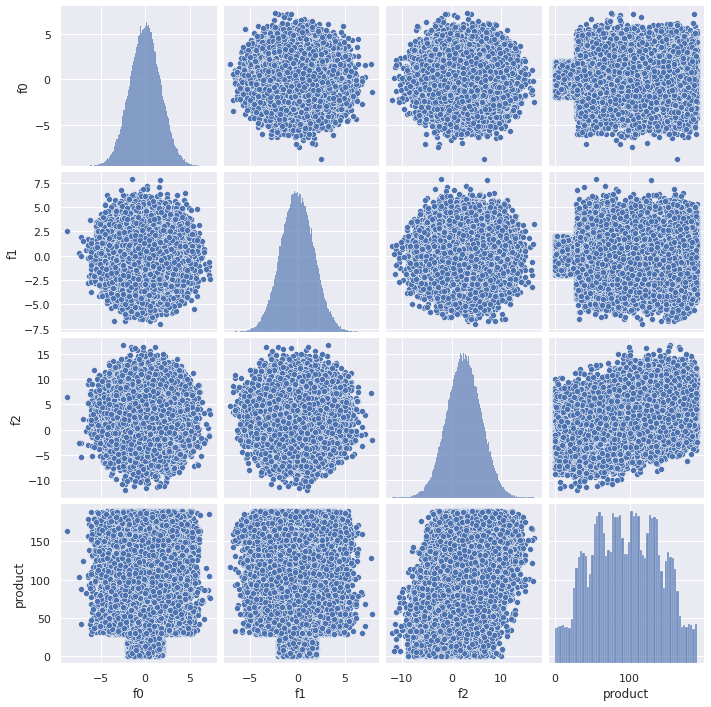

In [54]:
sns.pairplot(df_3)

### Вывод

Коррелирует во всех выборках параметр f2 с product, наилучшая корреляция у 2 региона, наихудшая - у третьего.

Типы данных указаны правильно, пропусков нет,можно приступать к исследованию

## Обучение и проверка модели

In [55]:
# Создадим функцию для разделения датафрейма на две выборки: валидационную и тренировочную
def split(target, features):
    target_train,target_valid,features_train, features_valid = train_test_split(target, features,test_size=0.25, random_state=123)
    return target_train, features_train, target_valid,features_valid

In [56]:
# Создадим функцию для масштабирования количественных признаков

def scaler(feature_train,feature_valid):
    scaler = StandardScaler()
    scaler.fit(feature_train)
    feature_train = scaler.transform(feature_train)
    feature_valid = scaler.transform(feature_valid)
    return feature_train,feature_valid

Чтобы не плодить лишние столбцы исключим из dataframe столбец 'id',он не понадобится для обучения модели.

In [57]:
df_1 = df_1.drop('id',axis=1)
df_2 = df_2.drop('id',axis=1)
df_3 = df_3.drop('id',axis=1)

In [58]:
# выделим целевой признак и отделим параметры

target_df_1 = df_1['product']
features_df_1 = df_1.drop('product',axis=1)

target_df_2 = df_2['product']
features_df_2 = df_2.drop('product',axis=1)

target_df_3 = df_3['product']
features_df_3 = df_3.drop('product',axis=1)

In [59]:
#Выполняем разбиение на тренировочную и валидационную выборки для каждого df

target_train_df_1, features_train_df_1, target_valid_df_1, features_valid_df_1 = split(target_df_1,features_df_1)
target_train_df_2, features_train_df_2, target_valid_df_2, features_valid_df_2 = split(target_df_2,features_df_2)
target_train_df_3, features_train_df_3, target_valid_df_3, features_valid_df_3 = split(target_df_3,features_df_3)

# Масштабируем признаки

features_train_df_1,features_valid_df_1 = scaler(features_train_df_1,features_valid_df_1)
features_train_df_2,features_valid_df_2 = scaler(features_train_df_2,features_valid_df_2)
features_train_df_3,features_valid_df_3 = scaler(features_train_df_3,features_valid_df_3)


Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)

In [60]:
# Создадим функцию которая на выходе будет передавать предсказания, среднеквадротичное отклонение и среднее значение выборки
def model(target_train, features_train, target_valid, features_valid):
    model = LinearRegression()
    model.fit(features_train,target_train)
    pred_valid = model.predict(features_valid)
    mean_product_pred = sum(pred_valid)/len(pred_valid)
    MSE = mean_squared_error(target_valid, pred_valid)
    summ = sum(pred_valid)
    return pred_valid, mean_product_pred, MSE,summ

In [61]:
# Применим вышеописанную функцию к каждому региону и выведем знаечния на экран

pred_valid_df_1,mean_product_pred_1, MSE_1,summ_1 = model(target_train_df_1, features_train_df_1, target_valid_df_1, features_valid_df_1)
print(f'Cредний запас предсказанного сырья для первой области:{mean_product_pred_1}')
print()
print(f'RMSE для первой области:{MSE_1**0.5}')
print()
print()
pred_valid_df_2,mean_product_pred_2, MSE_2,summ_2 = model(target_train_df_2, features_train_df_2, target_valid_df_2, features_valid_df_2)
print(f'Cредний запас предсказанного сырья для второй области:{mean_product_pred_2}')
print()
print(f'RMSE  для второй области:{MSE_2**0.5}')
print()
print()
pred_valid_df_3,mean_product_pred_3, MSE_3,summ_3 = model(target_train_df_3, features_train_df_3, target_valid_df_3, features_valid_df_3)
print(f'Cредний запас предсказанного сырья для третьей области:{mean_product_pred_3}')
print()
print(f'RMSE для третьей области:{MSE_3**0.5}')

Cредний запас предсказанного сырья для первой области:92.5493618911634

RMSE для первой области:37.64786282376177


Cредний запас предсказанного сырья для второй области:69.28001860653957

RMSE  для второй области:0.8954139804944314


Cредний запас предсказанного сырья для третьей области:95.09859933591403

RMSE для третьей области:40.12803006598514


### Вывод

Для первого и третьего региона среднее отклонение достаточно велико, более 35 тыс баррелей.

Для второго региона отклонение меньше 1 тысячи баррелей

Наименьший предсказанный запас находится во втором региона (69 тыс. баррелей), максимальное значение предсказания в третьем региона (95 тыс. баррелей)


## Подготовка к расчёту прибыли

In [62]:
BUDGET = 10_000_000_000 # Бюджет выделенный на разработку месторождений
ONE_PROD = 450_000 # Стоимость продажи одной тысячи баррелей нефти


In [63]:
break_even_point = math.ceil(BUDGET/ONE_PROD) # Точка безубыточности для месторождения, необходимое количество обьема добычи с месторождения
print(break_even_point)

22223


In [64]:
region_mean_reserve = [mean_product_pred_1,mean_product_pred_2,mean_product_pred_3] # создадим список средних значенийо бьема сырья для регионов


По условию: 

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

поссчитаем средний обьем сырья для каждого региона и сравним с точкой безубыточности.

In [65]:
for i in range(len(region_mean_reserve)):
    if region_mean_reserve[i] == mean_product_pred_1:
        print(f'Средний обьем запасов сырья в 1-м регионе: {mean_product_pred_1*200}')
        if mean_product_pred_1*200 >= break_even_point:
            print(f'Первый регион потенциально безубыточен')
    elif region_mean_reserve[i] == mean_product_pred_2:
        print(f'Средний обьем запасов сырья в 2-м регионе: {mean_product_pred_2*200}')
        if mean_product_pred_2*200 >= break_even_point:
            print(f'Второй регион потенциально безубыточен')
    else :
        print(f'Средний обьем запасов сырья в 3-м регионе: {mean_product_pred_3*200}')
        if mean_product_pred_3*200 >= break_even_point:
            print(f'Третий регион потенциально безубыточен')        

Средний обьем запасов сырья в 1-м регионе: 18509.87237823268
Средний обьем запасов сырья в 2-м регионе: 13856.003721307914
Средний обьем запасов сырья в 3-м регионе: 19019.719867182805


### Вывод 

Если ориентироваться на среднее значение обьема сырья в скважине, то к точке безубыточности ближе всего 3-й регион с значением 19019 тыс бареллей.


## Расчёт прибыли и рисков 

По условию задачи отбирается 200 лучших скважин, отсортируем имеющиеся предсказания и выберем 200 самых обьемных.

In [66]:
def conditioning(target_valid,pred_valid):
    target_valid = target_valid.reset_index(drop=True)
    pred_valid = pd.Series(pred_valid)
    return target_valid,pred_valid



In [67]:
target_valid_df_1, pred_valid_df_1 = conditioning(target_valid_df_1,pred_valid_df_1)
target_valid_df_2, pred_valid_df_2 = conditioning(target_valid_df_2, pred_valid_df_2)
target_valid_df_3, pred_valid_df_3 = conditioning(target_valid_df_3, pred_valid_df_3)

In [68]:
# Создадим функцию для рассчета прибыли
def revenue(target,pred,count):
    
    #target = target.reset_index(drop=True)
    #pred = pd.Series(pred)
    pred_sorted = pred.sort_values(ascending = False)
    selected = target[pred_sorted.index][:count] 
    return (ONE_PROD*sum(selected)) - BUDGET

Посчитаем обем 200 лучших скважин и их прибыльность.

In [69]:
best_df_1 = revenue(target_valid_df_1,pred_valid_df_1,200)

print(f'Прибыль для 200 лучших скважен 1-го региона:{best_df_1/1_000_000_000:.2f} млрд рублей')

Прибыль для 200 лучших скважен 1-го региона:3.53 млрд рублей


In [70]:
best_df_2 = revenue(target_valid_df_2,pred_valid_df_2,200)

print(f'Прибыль для 200 лучших скважен 2-го региона:{best_df_2/1_000_000_000:.2f} млрд рублей')

Прибыль для 200 лучших скважен 2-го региона:2.42 млрд рублей


In [71]:
best_df_3 = revenue(target_valid_df_3,pred_valid_df_3,200)

print(f'Прибыль для 200 лучших скважен 3-го региона:{best_df_3/1_000_000_000:.2f} млрд рублей')

Прибыль для 200 лучших скважен 3-го региона:2.37 млрд рублей


#### Вывод

Наибольший суммарный обьем сырья для 200 скважин в 1 регионе (18.97 млн баррелей). Прибыль для этого региона составляет -1.46 млрд рублей



In [72]:
state = RandomState(123)

In [73]:

# Создадим функцию и помощью техники Bootstrap получим распределение прибыли
def bootstrap(target_df,pred_valid_df):

   
    values = [] # Список для значений прибыли

    for i in range(1000): # создаем 1000 выборок по 500 значений
        target = target_df.sample(500, replace=True, random_state=state)
        pred = pred_valid_df[target.index]
        values.append(revenue(target,pred,200))
       
    values = pd.Series(values)
    profit_mean =  values.mean()  # Средняяя прибыль региона  
    lower = values.quantile(q=0.025) # Нижняя граница доверительного интервала
    upper = values.quantile(q=0.975) # Верхняя граница доверительного интервала   
    return profit_mean,lower, upper, values

In [74]:
#Рассчеты для 1-го региона
profit_mean_1,lower_1,upper_1,values1  = bootstrap(target_valid_df_1,pred_valid_df_1)
print(f'Средняя прибыль для 1-го региона:{profit_mean_1/1_000_000:.0f} млн. рублей')
print(f'95% доверительный интервал для значения средней прибыли 1-го региона:{lower_1/1_000_000:.2f} млн. до {upper_1/1_000_000:.2f} млн.')


Средняя прибыль для 1-го региона:505 млн. рублей
95% доверительный интервал для значения средней прибыли 1-го региона:-51.83 млн. до 1029.93 млн.


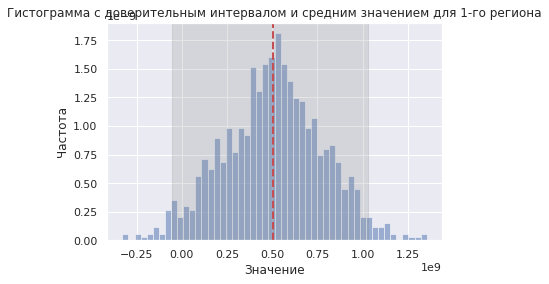

In [75]:
# строим гистограмму
ax = values1.hist(bins=50, density=True, alpha=0.5)
# добавляем на график вертикальную линию для среднего значения
ax.axvline(profit_mean_1, color='r', linestyle='dashed', linewidth=2)

# добавляем на график область для доверительного интервала
ax.axvspan(lower_1, upper_1, color='gray', alpha=0.2)

# добавляем на график подписи осей и заголовок
ax.set_xlabel('Значение')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма с доверительным интервалом и средним значением для 1-го региона')
plt.show()

In [79]:
# оцениваем риски
def risk(values, reg):
    low = values[values < 0]
    risk = (low.count()/len(values))*100
    print(f'риск убытка для {reg}-го региона: {risk}%') 

In [80]:
risk(values1,lower_1, 1)

риск убытка для 1-го региона: 4.0%


In [81]:
#Рассчеты для 2-го региона
profit_mean_2,lower_2,upper_2,values2 = bootstrap(target_valid_df_2,pred_valid_df_2)
print(f'Средняя прибыль для 2-го региона:{profit_mean_2/1_000_000:.0f} млн. рублей')
print(f'95% доверительный интервал для значения средней прибыли 2-го региона:{lower_2/1_000_000:.2f} млн. до {upper_2/1_000_000:.2f} млн.')

Средняя прибыль для 2-го региона:526 млн. рублей
95% доверительный интервал для значения средней прибыли 2-го региона:100.01 млн. до 945.01 млн.


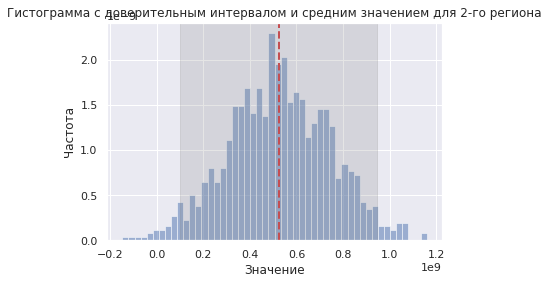

In [82]:
# строим гистограмму
ax = values2.hist(bins=50, density=True, alpha=0.5)
# добавляем на график вертикальную линию для среднего значения
ax.axvline(profit_mean_2, color='r', linestyle='dashed', linewidth=2)

# добавляем на график область для доверительного интервала
ax.axvspan(lower_2, upper_2, color='gray', alpha=0.2)

# добавляем на график подписи осей и заголовок
ax.set_xlabel('Значение')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма с доверительным интервалом и средним значением для 2-го региона')
plt.show()

In [83]:
risk(values2,lower_2, 2)

риск убытка для 2-го региона: 0.8999999999999999%


In [84]:
#Рассчеты для 3-го региона
profit_mean_3,lower_3,upper_3,values3 = bootstrap(target_valid_df_3,pred_valid_df_3)
print(f'Средняя прибыль для 2-го региона:{profit_mean_3/1_000_000:.0f} млн. рублей')
print(f'95% доверительный интервал для значения средней прибыли 3-го региона:{lower_3/1_000_000:.2f} млн. до {upper_3/1_000_000:.2f} млн.')

Средняя прибыль для 2-го региона:387 млн. рублей
95% доверительный интервал для значения средней прибыли 3-го региона:-174.25 млн. до 933.80 млн.


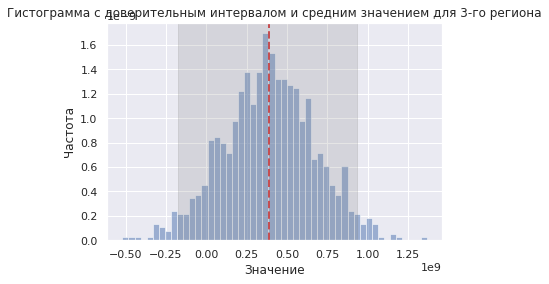

In [85]:
# строим гистограмму
ax = values3.hist(bins=50, density=True, alpha=0.5)
# добавляем на график вертикальную линию для среднего значения
ax.axvline(profit_mean_3, color='r', linestyle='dashed', linewidth=2)

# добавляем на график область для доверительного интервала
ax.axvspan(lower_3, upper_3, color='gray', alpha=0.2)

# добавляем на график подписи осей и заголовок
ax.set_xlabel('Значение')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма с доверительным интервалом и средним значением для 3-го региона')
plt.show()

In [86]:
risk(values3,lower_3, 3)

риск убытка для 3-го региона: 7.7%


#### Вывод

В доверительный интервал входят средняя прибыль для всех регионов

Средняя прибыль для 1-го региона - 505  млн. рублей 

Средняя прибыль для 2-го региона - 526  млн. рублей

Средняя прибыль для 3-го региона - 387 млн 

Риск убыточности меньше 2.5 % только у второго региона

## Вывод

С помощью модели линейной регрессии были получены предсказания обьема сырья в скважинах трех регионов.

Для каждого региона были посчитаны средние значения запасов сырья и среднее квадратичное отклонение. Наиболее точным оказалось предсказание для второго региона. Самое большое значение RMSE в 3-м регионе (40 тыс баррелей отклонение)

Среднее значение для второго региона наименьшее из предсказанных.

Для каждого региона были посчитаны обьемы запасов 200 скважин. Наибольшее среднее значение находится в 3 регионе (19019 тыс баррелей), но и оно не достигает точки безубыточности в 22223 тыс баррелей.

Наибольшая прибыль в 1 регионе из 200 лучших скважин 3.53 млрд рублей, на втором месте 3 регион - 2.37 млрд рублей.

С помощью теник и Bootstrep было найдено среднее значение прибыли для каждого региона, доверительный интервал для этих значений и прибыль/убыток месторождения.
Все значения средней прибыли попадают в 95% доверительный интервал . Наибольшаяй прибыль в 2 регионе (526 млн. рублей).
Риск убыточности меньше 2.5 % только у второго региона(0,9%)
Основываясь на результатах проведенного исследования предлагаю осваивать 2 регион. В нем нибольшие показатели средней прибыли с помощью Bootstrep и наименьший риск убыточности.